In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from galaxy2galaxy import problems
import tensorflow as tf
from scipy import fftpack 
from scipy.ndimage import gaussian_filter, convolve
import seaborn as sns

# set seaborn theme and style
sns.set_theme()
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})

#remove grid from images
sns.set_style("whitegrid", {'axes.grid' : False})

tf.enable_eager_execution()

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

tf.version.VERSION

In [2]:
import sys
path = '/home/astro/akhaury/GitHub/ADMM/'
sys.path.insert(1, path)

import plot_utils
from helper_func import *

data_path = '/home/astro/akhaury/Data/'

In [3]:
tf.executing_eagerly()

True

### Pre-processing Function

In [4]:
SNR = 80.0

def pre_proc_unet(dico):
    r"""Preprocess the data and adds noise to generate the input galaxy images.

    This function takes the dictionnary of galaxy images and PSFs for the input and
    the target and returns a list containing 3 arrays: an array of noisy galaxy images, 
    an array of target galaxy images, and an array of PSFs

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 3 arrays: an array of noisy galaxy images, 
        an array of target galaxy images, and an array of PSFs
    
    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    # Add noise
    # For the estimation of CFHT noise standard deviation check section 3 of:
    # https://github.com/CosmoStat/ShapeDeconv/blob/master/data/CFHT/HST2CFHT.ipynb

    sigma = tf.norm(dico['inputs']) / SNR
    noise = tf.random_normal(shape=tf.shape(dico['inputs']), mean=0.0, stddev=sigma, dtype=tf.float32)
    dico['inputs'] = dico['inputs'] + noise
    dico['targets'] /= 4000
    dico['inputs'] /= 4000
    dico['psf'] = dico['psf_cfht']/dico['psf_hst']
    
    # Compute IRFFT of PSF
    dico['psf'] = tf.signal.ifftshift(tf.signal.irfft2d(tf.cast(tf.squeeze(dico['psf']), tf.complex64)))
    
    # Resize to 64 X 64 using area interpolation
    dico['psf'] = tf.squeeze(tf.image.resize(tf.expand_dims(dico['psf'], axis=-1), size=(64,64), method='area'))
    
    # Normalize the PSF
    dico['psf'] /= tf.math.reduce_sum(dico['psf'])
    
    shift = [-1,-1]
    return tf.roll(tf.squeeze(dico['inputs']), shift, axis=[0,1]), tf.roll(tf.squeeze(dico['targets']), shift, axis=[0,1]), tf.roll(tf.squeeze(dico['psf']), shift, axis=[0,1]), sigma


### Loading Galaxy Images & PSF

In [5]:
with tf.compat.v1.Session() as sess:
    
    # Let's create an instance of the meerkat_3600 problem
    Modes = tf.estimator.ModeKeys
    problem128 = problems.problem('attrs2img_cosmos_parametric_cfht2hst')
    dset = problem128.dataset(Modes.EVAL, data_dir=data_path+'attrs2img_cosmos_parametric_cfht2hst')
    dset = dset.repeat()
    dset = dset.map(pre_proc_unet)
    n_batch = 128
    dset = dset.batch(n_batch)

    # Build an iterator over the dataset
    iterator = dset.make_one_shot_iterator().get_next()

    # Initialize batch
    batch = sess.run(iterator)


INFO:tensorflow:Reading data files from /home/astro/akhaury/Data/attrs2img_cosmos_parametric_cfht2hst/attrs2img_cosmos_parametric_cfht2hst-dev*
INFO:tensorflow:partition: 0 num_data_files: 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




### Load Trained U-Net Models

In [9]:
model_1 = tf.keras.models.load_model(path+'UNet_Denoiser/Models/UNet_param_ep{10}spe{6250}nb{32}', compile=False)

# ADMM in TensorFlow

In [10]:
# Projection - Enforce non-negative values
def proj(xi):
    
    return tf.cast(tf.math.maximum(xi, 0.0), tf.float32)

 
# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


# The gradient
def grad(y, x_rec, psf):

    return Ht(H(x_rec, psf) - y, psf)


# The cost function
def cost_func(y, x_rec, z, mu, rho, psf, var):

    temp = z - x_rec
    shape = mu.get_shape().as_list()
    
    cost_val = ( tf.cast(0.5, tf.float32) * rho * tf.norm(temp)**2  -
                 tf.matmul(tf.reshape(mu, [1, shape[0]*shape[1]]), tf.reshape(temp, [shape[0]*shape[1], 1]))  +
                 (tf.cast(0.5, tf.float32) / var) * tf.norm(y - H(x_rec, psf))**2 )
     
    return tf.keras.backend.eval(cost_val).flatten()


# Spectral value
def max_sv(psf, sigma, rho):
    
    H = tf.signal.fft2d(tf.cast(psf, tf.complex64))
    normH = tf.math.abs(tf.reverse(tf.reverse(H, axis=[0]), axis=[1]) * H  +  tf.cast(rho*sigma**2, tf.complex64))
    return tf.cast(tf.math.reduce_max(normH), tf.float32)
     
    
# Compute gradient step size   
def get_alpha(rho, sv, sigma):

    return (tf.cast(1.0, tf.float32) / 
            ((sv/(sigma**2) + rho) * tf.cast(1.0 + 1.0e-5, tf.float32)))


# Run ADMM
def runADMM(y, x_0, psf, grad, z_0, mu_0, rho_0, rho_max, eta, gamma, sigma_noise, disp_step, n_iter, model):   
    
    # Convert arrays to tensors
    
    x_0 = tf.cast(x_0, tf.float32)
    z_0 = tf.cast(z_0, tf.float32)
    mu_0 = tf.cast(mu_0, tf.float32)
    rho_0 = tf.cast(rho_0, tf.float32)          # Augmented lagrangian hyperparameter
    rho_max = tf.cast(rho_max, tf.float32)      # max rho value
    eta = tf.cast(eta, tf.float32)              # should be between - [0, 1)
    gamma = tf.cast(gamma, tf.float32)          # multiplicative rho factor -- Should be > 1   
    
    # declare variables    
    cost = np.full(n_iter, np.inf)
    nmse_arr = np.full(n_iter, np.inf)
    
    # ADMM parameters
    
    x_k = x_0
    z_k = z_0
    mu_k = mu_0
    rho_k = rho_0                                  # Augmented lagrangian hyperparameter
    delta_k = tf.cast(0.0, tf.float32)      

    # FISTA parameters
    
    t_k = tf.cast(1.0, tf.float32)
    z_fista_old = z_0
    sigma = tf.cast(sigma_noise, tf.float32)
      
    # square of spectral radius of convolution matrix
    
    sv = max_sv(psf, sigma, rho_k)           

    # The gradient descent step
    
    alpha = get_alpha(rho_k, sv, sigma)     
    
    # ADMM Loop 
    
    for k in range(n_iter): 
        
        ## FISTA update
        
        x_k1 = z_fista_old - alpha * (grad(y, z_fista_old, psf)  + 
                                      mu_k * sigma**2  + 
                                      rho_k * sigma**2 * (z_fista_old - z_k)) 
        
        x_k1 = proj(x_k1)             # Project negative values
        
        t_k1 = ( (tf.cast(1.0, tf.float32) + tf.math.sqrt(tf.cast(4.0, tf.float32)*t_k**2 + tf.cast(1.0, tf.float32))) 
                / tf.cast(2.0, tf.float32) )
        
        lambda_fista = tf.cast(1.0, tf.float32) + (t_k -  tf.cast(1.0, tf.float32)) / t_k1
        
        z_fista_new = x_k + lambda_fista * (x_k1 - x_k)
        
        z_fista_old = z_fista_new
        t_k = t_k1               
    
        ## Denoising sub-step
     
        z_k1 = x_k1 + (mu_k / rho_k)
              
        # U-Net Denoising
    
        z_k1 = tf.expand_dims(tf.expand_dims(z_k1, axis=0), axis=-1)
        z_k1 = tf.cast(tf.squeeze(model(z_k1)), tf.float32)
        
        ## mu update
        
        mu_k1 = mu_k + (x_k1 - z_k1) * rho_k
               
        ## Cost
        
        cost[k] = cost_func(y, x_k1, z_k1, mu_k1, rho_k, psf, var=sigma**2)            
        
        ## Rho & alpha update       

        test1 = (tf.math.abs(gamma * rho_k) < tf.math.abs(rho_max))

        delta_k1 = tf.cond(test1, lambda: (tf.cast(1.0/gal_input.get_shape().as_list()[0], tf.float32) * 
                                           (tf.norm(x_k1 - x_k) + tf.norm(z_k1 - z_k) + tf.norm(mu_k1 - mu_k))), 
                                  lambda: delta_k)
                
        test2 = (test1 and (tf.math.abs(delta_k1) > tf.math.abs(eta * delta_k)))
        
        rho_k1 = tf.cond(test2, lambda: gamma * rho_k, lambda: rho_k)
        alpha = tf.cond(test2, lambda: get_alpha(rho_k1, sv, 1.0), lambda: alpha)            
        
        # Update all variables
        
        delta_k = tf.cond(test1, lambda: delta_k1, lambda: delta_k)
        rho_k = rho_k1
        x_k = x_k1
        mu_k = mu_k1
        z_k = z_k1
        sv = max_sv(psf, sigma, rho_k)
        
        # Update variables
        x_k = x_k1
                
        # Compute NMSE
        nmse_arr[k] = nmse(gal_target_nmse, x_k)  
        
        # Stopping Criteria
        if (np.abs(nmse_arr[k]-nmse_arr[k-1]) < 1e-7) or (np.abs(cost[k]-cost[k-1]) < 1e-7):
            return x_k, cost, nmse_arr

        # Display plots
        if (k+1)%disp_step==0:
            plot_utils.plot_iter(x_k, gal_target, y, k+1)
          
        
    return x_k, cost, nmse_arr

### Model 1 (U-Net trained on Parametric Data)



 Galaxy Index = 21




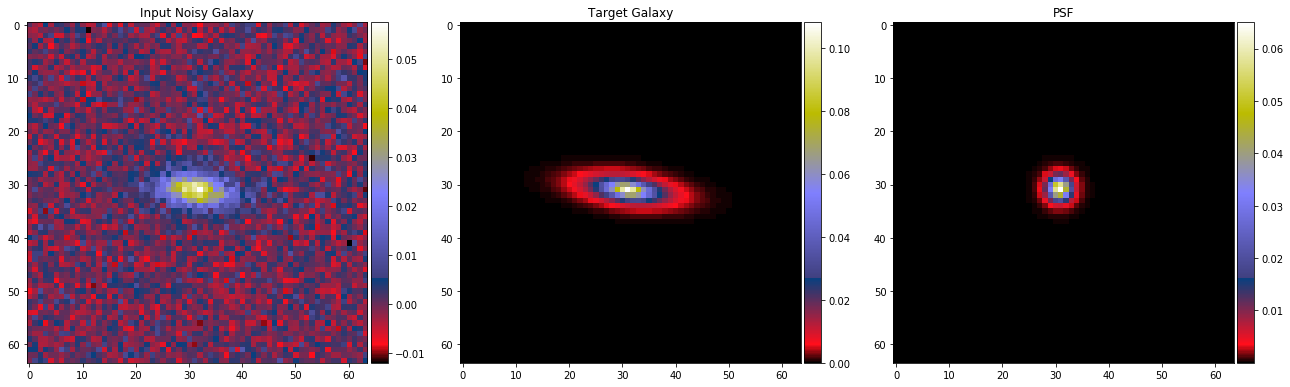

Noise Std = 0.0035230863094329835
SNR = 80.0
PSF Flux =  1.0


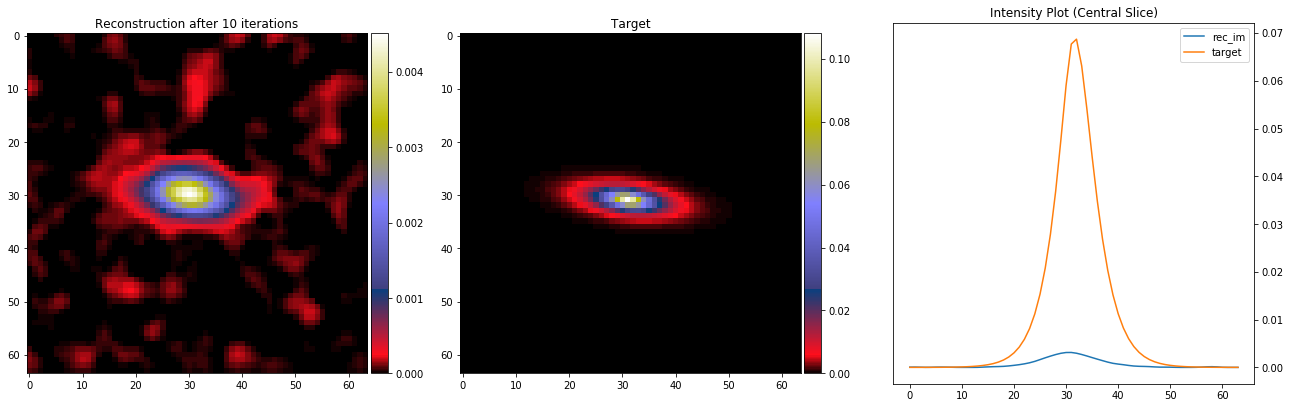

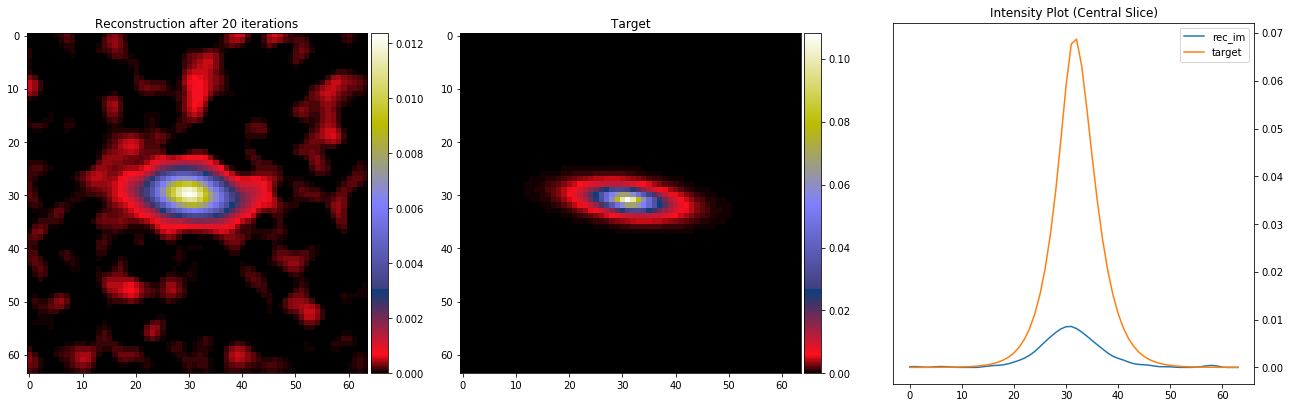

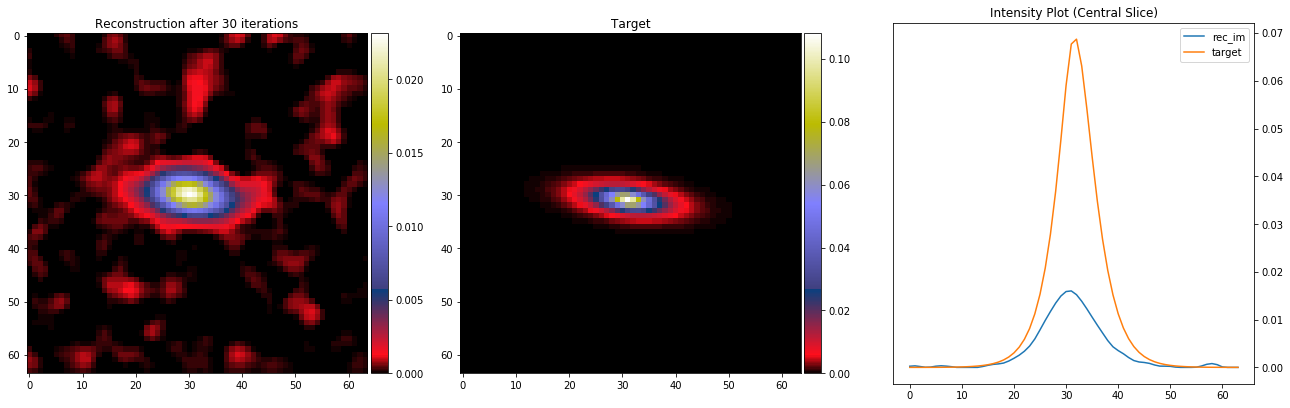

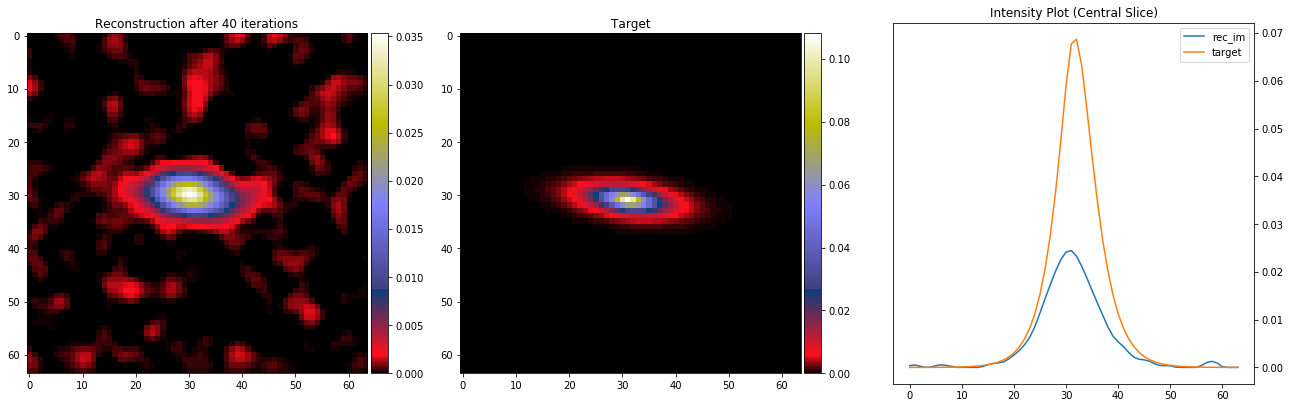

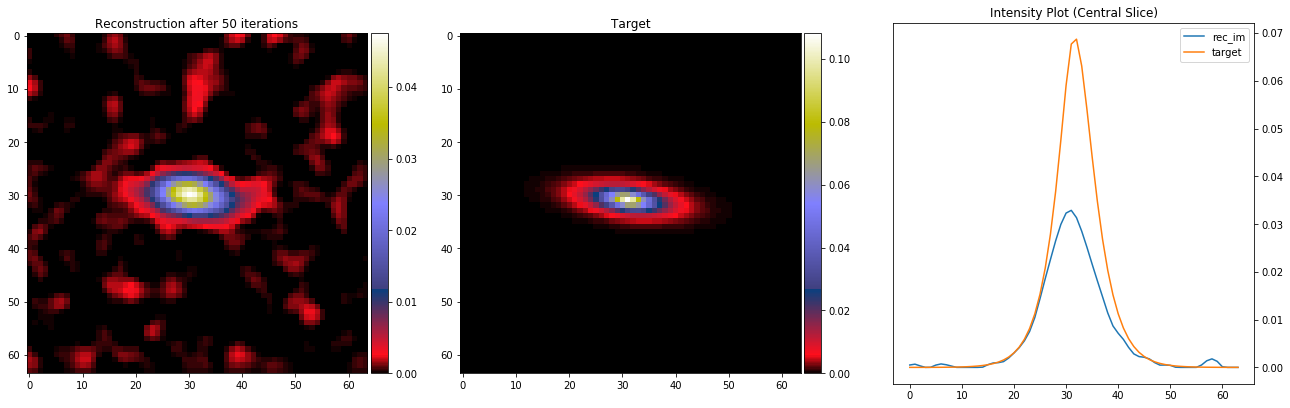

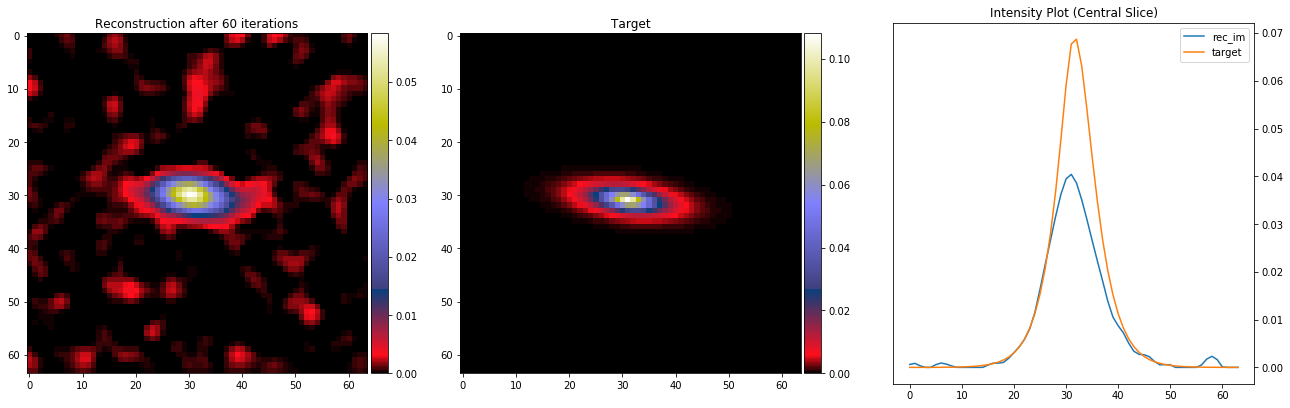

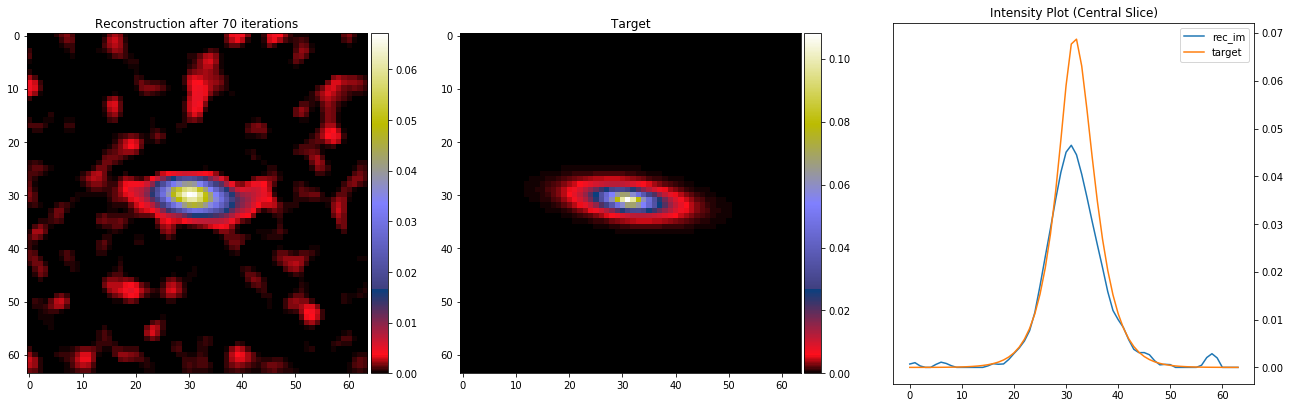

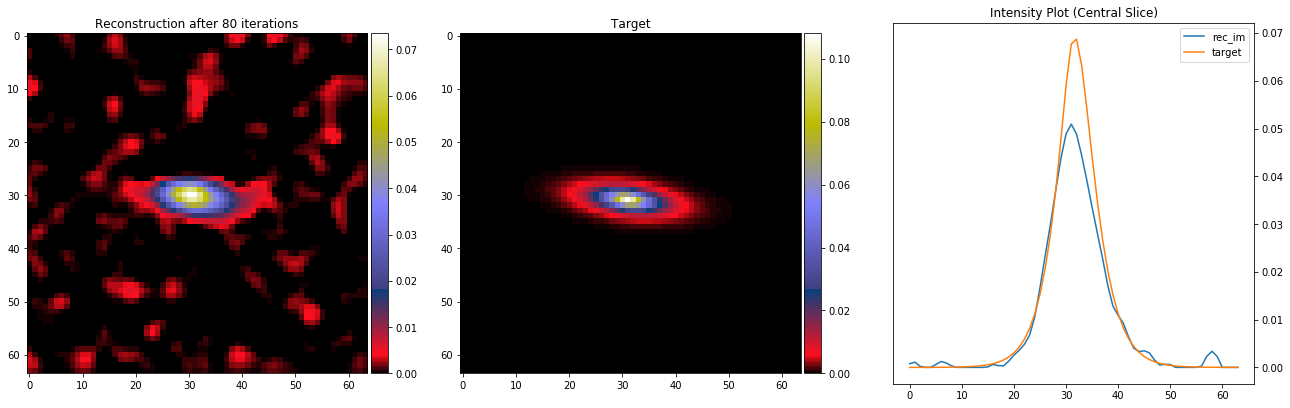

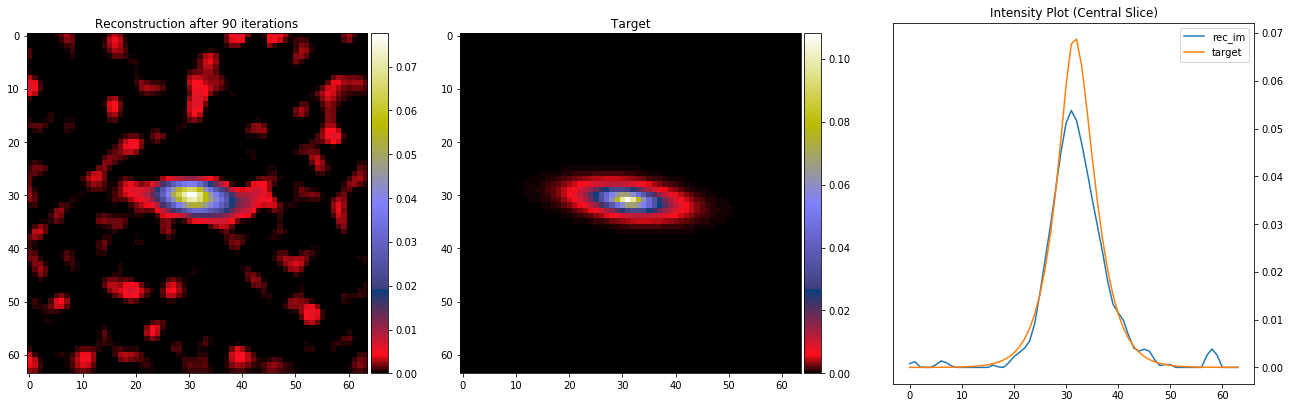

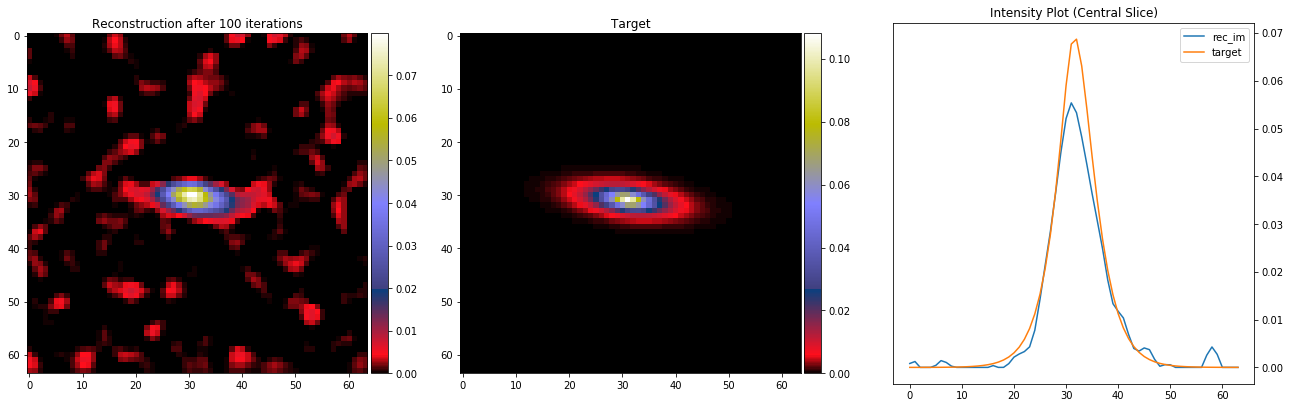


Flux after reconstruction =  5.613306895628018
Target Flux =  3.6036565
Error =  0.5576697857594423


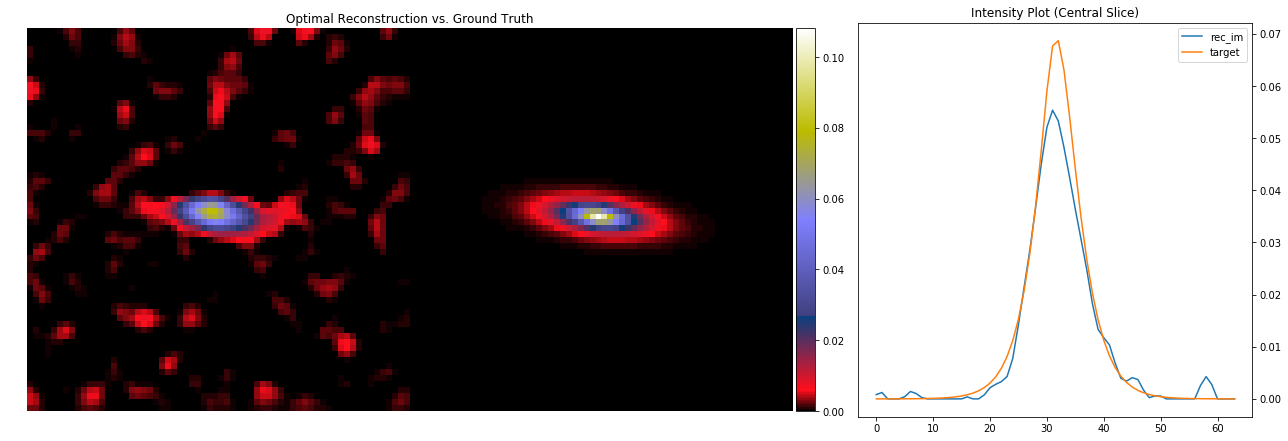

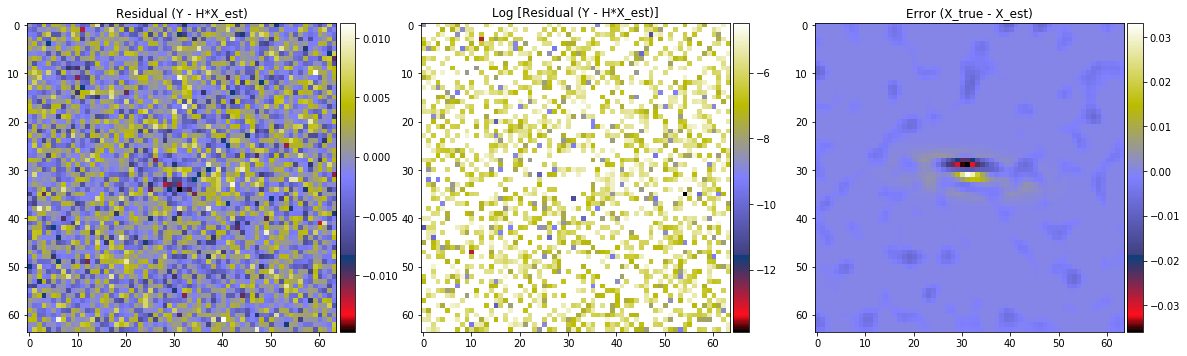

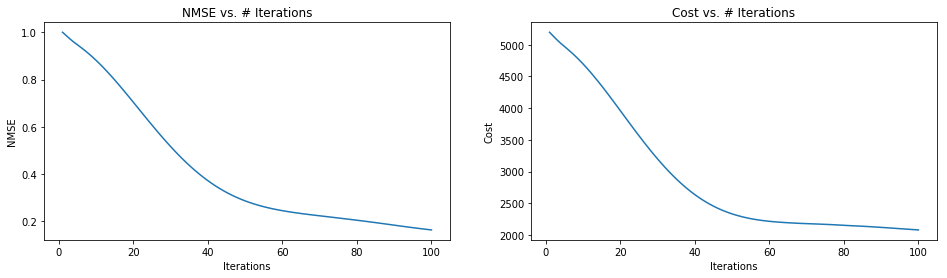



Minimum NMSE = 0.16368678212165833 (at [100] iterations)
Minimum Cost = 2081.95703125 (at [100] iterations)

_______________________________________________________________________________________________________




In [11]:
n_iter = 100    
disp_step = 10 
n_gal_deconv = n_batch

# ADMM parameters (initial)
x_0 = np.zeros(batch[0][0].shape)
z_0 = np.zeros(batch[0][0].shape)
mu_0 = 0.0                              
rho_0 = 50.0                     # Augmented lagrangian hyperparameter
rho_max = 200.0                  # max rho value
eta = 0.5                        # should be between - [0, 1)
gamma = 1.4                      # multiplicative rho factor -- Should be > 1

x_opt = np.zeros((n_gal_deconv, batch[0].shape[1], batch[0].shape[2]))                                 
nmse_arr = np.zeros((n_gal_deconv, n_iter))          
cost = np.zeros((n_gal_deconv, n_iter)) 


# Deconvolve given images
for gal_ind in [21]:   # Loop over galaxies
    
    gal_input = tf.cast(np.squeeze(batch[0][gal_ind]), tf.float32)
    gal_target = np.squeeze(batch[1][gal_ind])
    psf = tf.cast(np.squeeze(batch[2][gal_ind]) , tf.float32)  
    sigma = batch[3][gal_ind] / 4000.0   

    if gal_ind%1 == 0:
        
        print('\n\n Galaxy Index = {}'.format(gal_ind))
        
        # Plot input, target & psf 
        plot_utils.plot_gal_psf_opt(gal_input, gal_target, psf, sigma, SNR)

    
    # extract the central blob by thresholding
    gal_target_nmse = tf.cast((gal_target > 2*sigma) * gal_target, tf.float32)
      
    # Deconvolve the image
    x_opt[gal_ind], cost[gal_ind], nmse_arr[gal_ind] = runADMM(gal_input, x_0, psf, grad, z_0, mu_0, 
                                                               rho_0, rho_max, eta, gamma, sigma, 
                                                               disp_step, n_iter, model_1)
    if gal_ind%1 == 0:
        
        # Visual Comparison
        plot_utils.comparison(x_opt[gal_ind], gal_target, gal_input, psf, fftconvolve)

        # Plot NMSE & Cost
        plot_utils.nmse_cost(nmse_arr[gal_ind], cost[gal_ind], n_iter)